<a href="https://colab.research.google.com/github/martinpius/Applied-Predictive-Modeling2/blob/master/Cross_validation_for_Regression_and_classification_models_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n...please load your drive...")
def time_fmt(x:float = 123.98002)->float:
  h = int(x / (60 * 60))
  m = int(x % (60 * 60)/ 60)
  s = int(x % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"
print(f"...testing...testing...testing...\ntime elapse:{time_fmt()}")

Mounted at /content/drive
You are on colab with tensorflow version: 2.4.1
...testing...testing...testing...
time elapse:0: 002: 03.00


In [ ]:
import time, os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
pd.set_option('max_rows', 8)
pd.set_option('max_columns', 0)
plt.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
data = pd.read_csv("https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv", na_values = ['NA','?'])

In [ ]:
display(data.isna().value_counts())

id     job    area   income  aspect  subscriptions  dist_healthy  save_rate  dist_unhealthy  age    pop_dense  retail_dense  crime  product
False  False  False  False   False   False          False         False      False           False  False      False         False  False      1941
                     True    False   False          False         False      False           False  False      False         False  False        59
dtype: int64

In [ ]:
#Income has some missing values: replace with the median income:

In [ ]:
data['income'] = data['income'].fillna(data['income'].median())

In [ ]:
#For classification lets choose product as the target: We would like to know how
#individuals spends their income on average purchasing of various items:

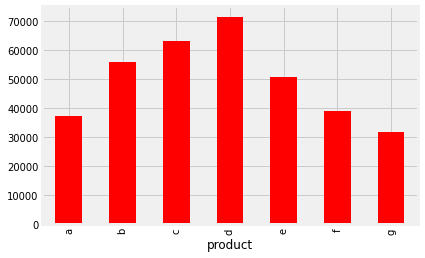

In [ ]:
data.groupby('product').income.mean().plot(kind = 'bar', color = 'red')

In [ ]:
#Product preferance also depends on other factors like age, pop_density etc
#Lets see how age may influence product preferance

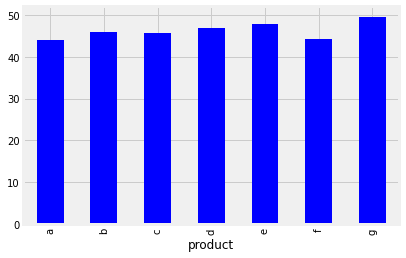

In [ ]:
data.groupby('product').age.mean().plot(kind = 'bar', color = 'blue')

In [ ]:
#Also we would like to see how the trend goes with other variables like population density:

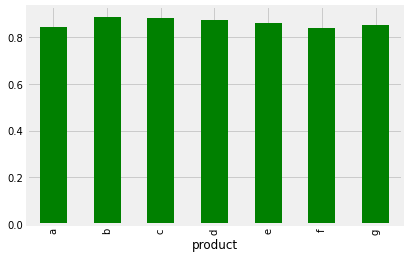

In [ ]:
data.groupby('product').pop_dense.mean().plot(kind = 'bar', color = 'green')

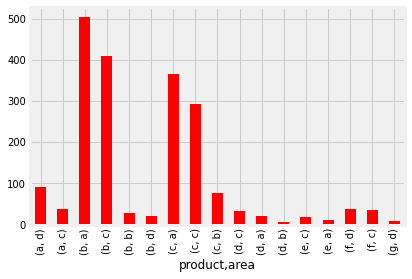

In [ ]:
#We may want to know how the locations may influence product preferances 
data.groupby('product').area.value_counts().plot(kind = 'bar', color = 'red')

In [ ]:
#From the above simple charts we may get general overview of the prediction power for the selected variables: Same
#analysis may be done on the remaining variables

In [ ]:
#Preparing the data for training our classification model:

In [ ]:
#Get the target and Convert to a dummy variable:

In [ ]:
target = pd.get_dummies(data['product'], prefix = 'product')

In [ ]:
data.drop(['id'],axis = 1, inplace = True)

In [ ]:
job_cat = pd.get_dummies(data['job'], prefix = 'job')
#subscriptions_cat = pd.get_dummies(data['subscriptions'], prefix = 'sbscr')
area_cat = pd.get_dummies(data['area'], prefix = 'area')


In [ ]:
data.drop(['area','job'], axis = 1, inplace = True)

In [ ]:
display(data)

,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,product
0,50876.0,13.100000,1,9.017895,35,11.738935,49,0.885827,0.492126,0.071100,b
1,60369.0,18.625000,2,7.766643,59,6.805396,51,0.874016,0.342520,0.400809,c
2,55126.0,34.766667,1,3.632069,6,13.671772,44,0.944882,0.724409,0.207723,b
3,51690.0,15.808333,1,5.372942,16,4.333286,50,0.889764,0.444882,0.361216,b
...,...,...,...,...,...,...,...,...,...,...,...
1996,26576.0,33.358333,2,3.632069,20,8.380497,38,0.944882,0.877953,0.063851,a
1997,28595.0,39.425000,3,7.168218,99,4.626950,36,0.759843,0.744094,0.098703,f
1998,67949.0,5.733333,0,8.936292,26,3.281439,46,0.909449,0.598425,0.117803,c
1999,61467.0,16.891667,0,4.312097,8,9.405648,48,0.925197,0.539370,0.451973,c


In [ ]:
#We obtain the standard scores for the continous columns to ensure uniformity:

In [ ]:
cols = data.drop('product', axis = 1).columns

In [ ]:
for col in cols:
  data[col] = zscore(data[col])

In [ ]:
display(data)

,income,aspect,subscriptions,dist_healthy,save_rate,dist_unhealthy,age,pop_dense,retail_dense,crime,product
0,-0.607550,-0.664918,-0.208449,-0.048411,-0.215764,-0.314089,0.854321,0.079279,-0.465765,-1.120315,b
1,0.338053,-0.207748,0.839031,-0.266765,0.196869,-0.915161,1.394432,-0.075010,-1.445372,0.682945,c
2,-0.184205,1.127906,-0.208449,-0.988286,-0.714362,-0.078604,-0.495957,0.850727,1.055205,-0.373087,b
3,-0.526467,-0.440815,-0.208449,-0.684488,-0.542432,-1.216347,1.124377,0.130709,-0.775115,0.466401,b
...,...,...,...,...,...,...,...,...,...,...,...
1996,-3.028085,1.011372,0.839031,-0.988286,-0.473660,-0.723260,-2.116291,0.850727,2.060592,-1.159964,a
1997,-2.826971,1.513363,1.886511,-0.371196,0.884591,-1.180569,-2.656402,-1.566477,1.184101,-0.969344,f
1998,1.093101,-1.274478,-1.255928,-0.062651,-0.370502,-1.344498,0.044154,0.387858,0.230272,-0.864885,c
1999,0.447425,-0.351174,-1.255928,-0.869615,-0.679976,-0.598362,0.584265,0.593578,-0.156415,0.962774,c


In [ ]:
#Combine all datasets 

In [ ]:
data = pd.concat([data, area_cat, subscriptions_cat, job_cat], axis = 1)

In [ ]:
x = data.drop('product', axis = 1).values

In [ ]:
print(f"x_shape: {x.shape}, target_shape: {target.shape}")

x_shape: (2000, 53), target_shape: (2000, 7)


In [ ]:
display(x)

array([[-0.60754957, -0.66491815, -0.20844851, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.33805295, -0.20774798,  0.83903145, ...,  0.        ,
         0.        ,  0.        ],
       [-0.18420492,  1.12790602, -0.20844851, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-2.82697122,  1.51336322,  1.88651142, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.09310058, -1.27447836, -1.25592848, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.44742528, -0.35117392, -1.25592848, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
#Checking for class imbalance:

In [ ]:
target = pd.get_dummies(data['product'], prefix = 'prod')

In [ ]:
y = target.values

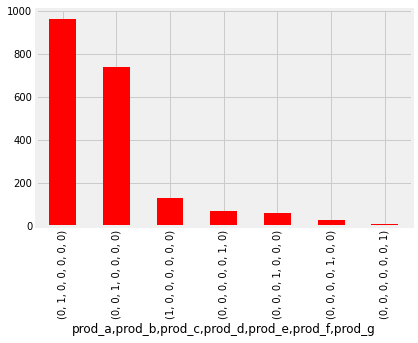

In [ ]:
target.value_counts().plot(kind = 'bar', color = 'red')

In [ ]:
#We can see that the categories for the class variable isn't well balanced 
#So we can retain the data structure by performing stratified cross-validation

In [ ]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 112)

In [ ]:
y_oos = []
pred_oos = []
fold = 0
for train, test in folds.split(x, data['product']):
  fold+=1
  print(f"fold number: {fold}")
  x_train = x[train]
  x_test = x[test]
  y_train = y[train]
  y_test = y[test]

  model = tf.keras.models.Sequential(name = 'mlp_scv')
  model.add(tf.keras.layers.Dense(units = 128, kernel_initializer = 'random_normal', activation ='relu', name = 'dense1'))
  model.add(tf.keras.layers.Dense(units = 64, kernel_initializer = 'random_normal', activation ='relu', name = 'dense2'))
  model.add(tf.keras.layers.Dense(units = target.shape[1], activation = 'softmax',name = 'outputs'))
  model.compile(loss = 'categorical_crossentropy', optimizer = 'RMSprop')
  model.fit(x_train, y_train, validation_data = (x_test, y_test), verbose = 2, epochs = 200)
  preds = model.predict(x_test)
  y_oos.append(y_test)
  preds = np.argmax(preds, axis = 1)
  pred_oos.append(preds)
  yc = np.argmax(y_test, axis = 1)
  acc_score = accuracy_score(yc, preds)
  print(f"the accuracy at fold: {k} is: {acc_score:.4f}")

y_oos = np.concatenate(y_oos)
pred_oos = np.concatenate(pred_oos)
y_c = np.argmax(y_oos, axis = 1)
acc_score_overall = accuracy_score(y_c, pred_oos)
print(f"overall accuracy {acc_score_overall:.4f}")

y_oos = pd.DataFrame(y_oos)
pred_oos = pd.DataFrame(pred_oos)
cv_dfm = pd.concat([y_oos, pred_oos])


fold number: 1
Epoch 1/200
50/50 - 1s - loss: 1.2231 - val_loss: 0.9592
Epoch 2/200
50/50 - 0s - loss: 0.8314 - val_loss: 0.8506
Epoch 3/200
50/50 - 0s - loss: 0.7509 - val_loss: 0.8341
Epoch 4/200
50/50 - 0s - loss: 0.7098 - val_loss: 0.8180
Epoch 5/200
50/50 - 0s - loss: 0.6808 - val_loss: 0.8110
Epoch 6/200
50/50 - 0s - loss: 0.6630 - val_loss: 0.8100
Epoch 7/200
50/50 - 0s - loss: 0.6442 - val_loss: 0.7999
Epoch 8/200
50/50 - 0s - loss: 0.6246 - val_loss: 0.7995
Epoch 9/200
50/50 - 0s - loss: 0.6142 - val_loss: 0.7857
Epoch 10/200
50/50 - 0s - loss: 0.6024 - val_loss: 0.7836
Epoch 11/200
50/50 - 0s - loss: 0.5886 - val_loss: 0.7673
Epoch 12/200
50/50 - 0s - loss: 0.5792 - val_loss: 0.7695
Epoch 13/200
50/50 - 0s - loss: 0.5736 - val_loss: 0.7694
Epoch 14/200
50/50 - 0s - loss: 0.5558 - val_loss: 0.7725
Epoch 15/200
50/50 - 0s - loss: 0.5515 - val_loss: 0.7855
Epoch 16/200
50/50 - 0s - loss: 0.5416 - val_loss: 0.7736
Epoch 17/200
50/50 - 0s - loss: 0.5332 - val_loss: 0.7704
Epoch 18